In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import TruncatedSVD
from nltk.tokenize import word_tokenize, wordpunct_tokenize, WhitespaceTokenizer, \
                          RegexpTokenizer, sent_tokenize, MWETokenizer
from nltk.util import ngrams
from nltk.chunk import ne_chunk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim
import warnings
import logging
import pickle

%matplotlib inline
pd.options.display.max_columns = 100

In [2]:
def get_sim_from_review_word2vec(word):
    try:
        return gensim_model.most_similar(word.lower())
    except Exception as e:
        return e

In [3]:
# this code doesn't work anymore after upgrading to pandas 0.20.1,
# will get ModuleNotFoundError: No module named 'pandas.indexes'
# with open("cleaned_data.pkl", 'rb') as picklefile: 
#     book_review = pickle.load(picklefile)
book_review = pd.read_pickle("cleaned_w_bknlp.pkl")

In [4]:
cond = book_review['review_desc_len'] == 0
review_coll = book_review.loc[~cond, ['bookid', 'userid', 'review_desc']].drop_duplicates()
review_coll.set_index(['bookid', 'userid'], inplace = True)

In [5]:
review_coll.tail(1)

,,review_desc
bookid,userid,
17261174,1722508,"Utterly charming, well paced, written and draw..."


In [6]:
row_order = review_coll.index

### preprocessing

In [7]:
review_coll['tokens'] = review_coll["review_desc"].map(lambda x: word_tokenize(x))
review_coll.tail(1)

,,review_desc,tokens
bookid,userid,,
17261174,1722508,"Utterly charming, well paced, written and draw...","[Utterly, charming, ,, well, paced, ,, written..."


In [8]:
stemmer = LancasterStemmer()
review_coll['stemmed'] = review_coll["tokens"].map(lambda x: " ".join([stemmer.stem(y) for y in x]))
review_coll.tail(1)

,,review_desc,tokens,stemmed
bookid,userid,,,
17261174,1722508,"Utterly charming, well paced, written and draw...","[Utterly, charming, ,, well, paced, ,, written...","ut charm , wel pac , writ and drawn . would al..."


### sentiment

In [9]:
sid = SentimentIntensityAnalyzer()

In [10]:
sid_df = review_coll.copy()
sid_df['dict'] = sid_df["stemmed"].map(sid.polarity_scores)
sid_df = pd.concat([sid_df.drop(['dict'], axis=1), sid_df['dict'].apply(pd.Series)], axis=1)
sid_df.tail(1)

,,review_desc,tokens,stemmed,compound,neg,neu,pos
bookid,userid,,,,,,,
17261174,1722508,"Utterly charming, well paced, written and draw...","[Utterly, charming, ,, well, paced, ,, written...","ut charm , wel pac , writ and drawn . would al...",0.6808,0.0,0.865,0.135


In [11]:
sid_df = sid_df.drop(['review_desc', 'tokens', 'stemmed'], axis = 1)
sid_df.reset_index(inplace = True)
sid_df.tail(1)

,bookid,userid,compound,neg,neu,pos
19216,17261174,1722508,0.6808,0.0,0.865,0.135


### more preprocessing

In [12]:
cv = TfidfVectorizer(strip_accents = 'unicode' 
                     , ngram_range = (1, 2)
                     , stop_words = "english"
                     , max_df = 0.5
                     , min_df = 5 # TODO raise this?
                     , norm = 'l2' # important to normalize?
                     )
review_coll = cv.fit_transform(review_coll['stemmed'])
review_coll = pd.DataFrame(review_coll.todense(), columns=[cv.get_feature_names()])
review_coll.tail(1)

,00,000,000 000,000 leagu,000 pag,000 peopl,000 word,000 year,01,02,03,04,05,06,07,08,09,10,10 000,10 10,10 11,10 12,10 15,10 20,10 book,10 minut,10 pag,10 read,10 recommend,10 second,10 star,10 tim,10 year,100,100 good,100 greatest,100 mor,100 pag,100 sur,100 tim,100 year,1000,1000 pag,1000 year,100th,100th birthday,101,102,104,106,...,یکی از,অন,আছ,আব,আম,আর,ইচছ,ইল,এই,এক,একট,এখন,এট,এমন,এর,ওয,কট,কত,কর,খক,খয,চছ,জনয,তব,তর,ধর,নট,নত,পড,পর,পরথম,বই,বইট,বইয,বয,বল,মত,মন,রণ,সব,হয,হল,งก,งท,งเร,นท,หล,อง,อเร,เป
19216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### get word2vec 

In [ ]:
# It barely works on my Mac...
# model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)  

In [13]:
gensim_input = list(review_coll.apply(lambda y: [x for x in review_coll.columns.where(y != 0) if type(x) == str], axis = 1))

In [14]:
gensim_model = gensim.models.Word2Vec(gensim_input, 
                                      seed = 0,
                                      window = 5,
                                      size = 100, # np.sqrt(len(gensim_input)),
                                      min_count = 6,
                                      sg = 1,
                                      iter = 5
                                     ) # TODO tune params

- get similarity

In [15]:
get_sim_from_review_word2vec("Neil")

[('neil gaim', 0.983185887336731),
 ('naz germany', 0.9652099609375),
 ('needless', 0.9625983238220215),
 ('naz', 0.9624735116958618),
 ('nerd', 0.96131432056427),
 ('nee mor', 0.9610462188720703),
 ('nalin', 0.9598002433776855),
 ('napoleon', 0.9584605693817139),
 ('navy', 0.9579448699951172),
 ('napoleon war', 0.9574493169784546)]

- plot word in latent vector space (using first two vectors)

In [16]:
wv_df = dict()
for key, val in gensim_model.wv.vocab.items():
        wv_df[key] = gensim_model.wv[key]
wv_df = pd.DataFrame(wv_df).transpose()
wv_df.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
00,0.267961,-0.077101,0.168271,-0.024101,0.045145,0.104516,0.103761,0.024089,-0.087505,0.038291,0.095961,-0.137457,-0.006577,0.090590,0.217450,-0.039204,0.008684,-0.106202,0.469475,-0.030907,-0.010414,0.103773,-0.113139,0.224882,-0.264277,0.346531,0.252471,-0.128159,-0.340629,0.073274,0.025127,0.059436,0.207555,-0.181731,0.147849,-0.288864,-0.039389,-0.257169,-0.011964,0.249169,0.248021,0.206932,-0.112593,-0.189728,-0.134944,0.019442,-0.313491,0.262409,0.082043,0.006154,0.057755,0.043434,0.158450,0.131774,-0.128364,-0.320368,-0.150141,-0.402178,0.025557,-0.172295,0.080588,0.143583,0.323179,-0.656934,0.039616,0.093920,-0.140308,-0.354221,0.112878,-0.281365,0.061117,-0.087594,-0.496753,-0.013145,0.256432,0.113208,0.151349,0.268100,0.009481,0.528695,0.082657,0.097557,0.038848,-0.414544,0.190808,-0.366723,0.211050,0.218941,0.002354,-0.107959,0.349517,-0.041677,-0.224859,-0.603036,0.162810,-0.213597,-0.165618,0.029111,0.587510,0.060460
000,0.385098,-0.096915,0.273698,-0.061128,-0.045297,0.168189,-0.037965,-0.122658,-0.221743,0.318134,0.245973,-0.242726,0.127216,0.157615,0.542713,-0.018427,-0.002804,-0.315869,0.515620,-0.076541,-0.015009,0.042142,-0.095727,0.608770,-0.492279,0.474378,0.512988,0.016690,-0.685494,0.049933,0.018257,0.136255,0.504438,-0.359196,0.590274,-0.468920,-0.341257,-0.646769,-0.021640,0.535016,0.182676,0.344828,-0.355706,-0.399604,-0.083943,0.092374,-0.614759,0.419978,0.070771,-0.220263,-0.099066,-0.057276,0.110977,0.194742,-0.142570,-0.510659,-0.290165,-0.666872,0.024759,-0.209222,0.034391,0.358535,0.649458,-0.974428,0.136475,0.207011,-0.395985,-0.574613,0.071390,-0.503640,0.400389,-0.088006,-0.849309,0.082685,0.202072,0.294077,0.092596,0.279749,0.105017,0.835260,0.142485,0.297527,0.040134,-0.814933,0.406180,-0.446720,0.298192,0.281836,-0.078936,-0.090336,0.241374,0.071247,-0.212410,-0.999328,0.343394,-0.298398,-0.299248,0.190873,0.953530,0.230262
000 000,0.256689,-0.054740,0.182856,-0.036043,-0.019670,0.079128,0.052528,-0.020808,-0.096078,0.018137,0.080082,-0.163951,-0.015425,0.119605,0.205763,-0.020450,0.019065,-0.127878,0.435719,0.005829,0.021459,0.099558,-0.106731,0.253356,-0.244446,0.377621,0.206909,-0.147179,-0.361146,0.089416,0.034001,0.062421,0.249283,-0.137140,0.236954,-0.270654,-0.104423,-0.259221,-0.000398,0.229673,0.196892,0.157706,-0.158580,-0.142303,-0.118073,0.010411,-0.316360,0.236786,0.093853,-0.000233,0.017152,0.017827,0.100438,0.132090,-0.171099,-0.363893,-0.145202,-0.382545,0.079378,-0.196547,0.103774,0.125695,0.298315,-0.634741,0.065920,0.118181,-0.173944,-0.347925,0.068470,-0.323745,0.098954,-0.061500,-0.539724,-0.037044,0.252214,0.156547,0.128352,0.196906,0.024405,0.530335,0.083702,0.098357,0.013155,-0.448956,0.215052,-0.331308,0.172879,0.149032,-0.027684,-0.081709,0.348506,-0.033225,-0.220047,-0.596896,0.183834,-0.207362,-0.196506,0.063726,0.602068,0.053602
000 pag,0.192207,-0.044174,0.145332,0.013399,-0.020489,0.081297,0.009360,-0.019622,-0.085437,0.041545,0.086067,-0.053693,0.022112,0.051561,0.230461,-0.043696,-0.003366,-0.119146,0.349699,-0.005479,-0.026697,0.076916,-0.097435,0.196835,-0.261054,0.278274,0.205551,-0.069684,-0.303271,0.033846,0.008867,0.072069,0.180017,-0.146396,0.192467,-0.216020,-0.064556,-0.219066,0.006294,0.194310,0.192315,0.125411,-0.118419,-0.165280,-0.067035,0.020128,-0.236216,0.237958,0.077436,0.035273,0.010066,-0.024698,0.095920,0.130430,-0.123792,-0.285402,-0.117622,-0.304630,0.060751,-0.175949,0.052446,0.131690,0.297505,-0.540082,0.052101,0.084090,-0.152132,-0.251182,0.066261,-0.221861,0.072622,-0.090965,-0.405416,-0.006811,0.214487,0.098441,0.134200,0.192353,0.020898,0.435223,0.086448,0.085279,0.002950,-0.347585,0.194284,-0.311659,0.154617,0.157167,0.019426,-0.096479,0.2376

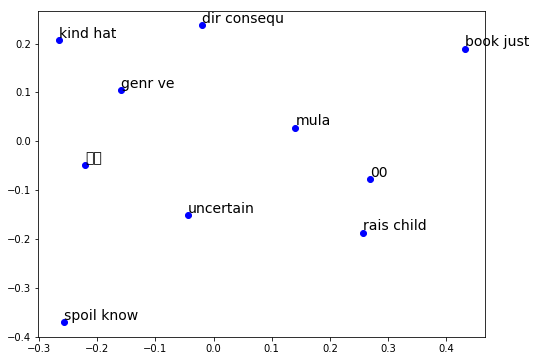

In [19]:
fig = plt.figure(figsize = (8, 6))
tot_words = wv_df.shape[0]
n_words_to_plot = 9
sample = range(0, tot_words, tot_words // n_words_to_plot)
ax = fig.add_subplot(111)
a = wv_df.iloc[sample, 0]
b = wv_df.iloc[sample, 1]
c = wv_df.index[sample]
plt.plot(a, b, "bo")
for tup in zip(a, b, c):                                      
    ax.annotate(tup[2], xy = (tup[0] + 0.0001, tup[1] + 0.005), textcoords='data', fontsize = 14)
plt.show()

### get latent features

In [20]:
init_n_components = 500 # min(review_coll.shape) - 1
init_n_components

500

In [21]:
tSVD_model = TruncatedSVD(n_components = init_n_components)
tSVD_model.fit(review_coll)

TruncatedSVD(algorithm='randomized', n_components=500, n_iter=5,
       random_state=None, tol=0.0)

In [22]:
var_ratio_df = pd.DataFrame(tSVD_model.explained_variance_ratio_)
var_ratio_df.columns = ['var_ratio']
var_ratio_df['cum_var_ratio'] = var_ratio_df['var_ratio'].cumsum()
var_ratio_df.head(1)

,var_ratio,cum_var_ratio
0,0.004466,0.004466


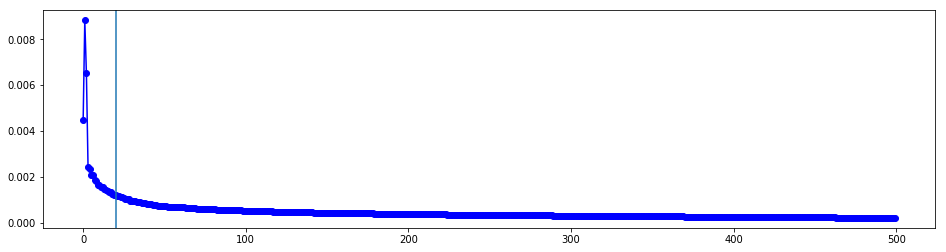

In [24]:
plt.figure(figsize = (16, 4))
plt.plot(var_ratio_df['var_ratio'], 'b-o')
plt.axvline(20)
plt.show()

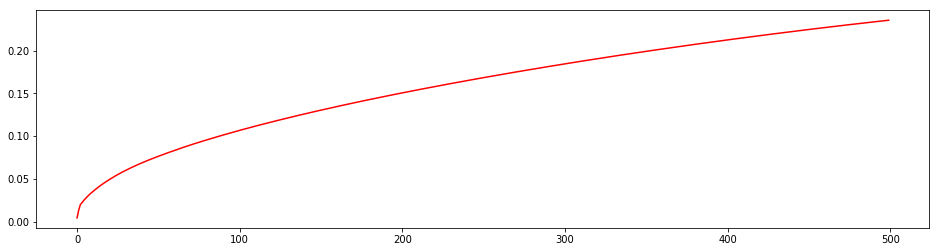

In [25]:
plt.figure(figsize = (16, 4))
plt.plot(var_ratio_df['cum_var_ratio'], 'r-')
plt.show()

In [26]:
elbow_n_components = 100 # TODO Or 3? Tune this?

In [27]:
U, Sigma, VT = randomized_svd(review_coll, 
                              n_components=elbow_n_components,
                              n_iter=5,
                              random_state=0)
print(review_coll.shape, U.shape, Sigma.shape, VT.shape)

(19217, 101521) (19217, 100) (100,) (100, 101521)


In [28]:
# reconstruc_recomm_by_stars = pd.DataFrame(np.dot(U, np.dot(np.diag(Sigma), VT)))
# reconstruc_recomm_by_stars.index = recomm_by_stars.index
# reconstruc_recomm_by_stars.columns = recomm_by_stars.columns
# print(reconstruc_recomm_by_stars.shape)
# reconstruc_recomm_by_stars.iloc[:5, :5]

In [29]:
review_latent = pd.DataFrame(U)
review_latent.index = review_coll.index
review_latent.columns = pd.Series(review_latent.columns).map(lambda x: 'review_latent' + str(x))
review_latent.tail(1)

,review_latent0,review_latent1,review_latent2,review_latent3,review_latent4,review_latent5,review_latent6,review_latent7,review_latent8,review_latent9,review_latent10,review_latent11,review_latent12,review_latent13,review_latent14,review_latent15,review_latent16,review_latent17,review_latent18,review_latent19,review_latent20,review_latent21,review_latent22,review_latent23,review_latent24,review_latent25,review_latent26,review_latent27,review_latent28,review_latent29,review_latent30,review_latent31,review_latent32,review_latent33,review_latent34,review_latent35,review_latent36,review_latent37,review_latent38,review_latent39,review_latent40,review_latent41,review_latent42,review_latent43,review_latent44,review_latent45,review_latent46,review_latent47,review_latent48,review_latent49,review_latent50,review_latent51,review_latent52,review_latent53,review_latent54,review_latent55,review_latent56,review_latent57,review_latent58,review_latent59,review_latent60,review_latent61,review_latent62,review_latent63,review_latent64,review_latent65,review_latent66,review_latent67,review_latent68,review_latent69,review_latent70,review_latent71,review_latent72,review_latent73,review_latent74,review_latent75,review_latent76,review_latent77,review_latent78,review_latent79,review_latent80,review_latent81,review_latent82,review_latent83,review_latent84,review_latent85,review_latent86,review_latent87,review_latent88,review_latent89,review_latent90,review_latent91,review_latent92,review_latent93,review_latent94,review_latent95,review_latent96,review_latent97,review_latent98,review_latent99
19216,0.002696,-0.000392,-0.000089,-0.002709,-0.000069,-0.000358,-0.000184,0.000142,0.000002,0.000008,-0.000309,0.000728,-0.000119,-0.001153,0.000287,-0.000038,0.000019,-0.000395,-0.002927,-0.001046,-0.001136,-0.003125,0.002275,0.000296,0.001338,0.000147,-0.002719,0.005465,-0.003741,0.001688,-0.004214,-0.001423,-0.002744,0.000441,-0.005863,-0.007172,0.008884,0.009567,0.005619,-0.003575,0.007334,-0.000245,0.000549,-0.004813,0.001742,-0.001482,-0.005253,-0.000873,0.000626,-0.002938,0.001376,0.00305,0.005684,-0.000241,0.00478,-0.000377,0.000885,0.002404,0.00445,0.003875,0.002678,0.000861,-0.005148,0.008016,-0.000081,0.002868,-0.000354,-0.00907,0.00166,0.004749,-0.00871,0.003954,-0.001457,-0.000697,0.001867,0.010382,-0.000076,0.002843,0.005323,-0.002851,0.006514,0.00661,0.005314,-0.003897,0.000444,-0.001907,-0.001712,0.001842,-0.004009,-0.001429,-0.005232,-0.002083,-0.001466,-0.008617,0.008751,-0.006065,-0.003368,-0.002098,0.001536,0.00314


In [30]:
review_latent.index = row_order
review_latent.reset_index(inplace = True)
review_latent.tail(1)

,bookid,userid,review_latent0,review_latent1,review_latent2,review_latent3,review_latent4,review_latent5,review_latent6,review_latent7,review_latent8,review_latent9,review_latent10,review_latent11,review_latent12,review_latent13,review_latent14,review_latent15,review_latent16,review_latent17,review_latent18,review_latent19,review_latent20,review_latent21,review_latent22,review_latent23,review_latent24,review_latent25,review_latent26,review_latent27,review_latent28,review_latent29,review_latent30,review_latent31,review_latent32,review_latent33,review_latent34,review_latent35,review_latent36,review_latent37,review_latent38,review_latent39,review_latent40,review_latent41,review_latent42,review_latent43,review_latent44,review_latent45,review_latent46,review_latent47,...,review_latent50,review_latent51,review_latent52,review_latent53,review_latent54,review_latent55,review_latent56,review_latent57,review_latent58,review_latent59,review_latent60,review_latent61,review_latent62,review_latent63,review_latent64,review_latent65,review_latent66,review_latent67,review_latent68,review_latent69,review_latent70,review_latent71,review_latent72,review_latent73,review_latent74,review_latent75,review_latent76,review_latent77,review_latent78,review_latent79,review_latent80,review_latent81,review_latent82,review_latent83,review_latent84,review_latent85,review_latent86,review_latent87,review_latent88,review_latent89,review_latent90,review_latent91,review_latent92,review_latent93,review_latent94,review_latent95,review_latent96,review_latent97,review_latent98,review_latent99
19216,17261174,1722508,0.002696,-0.000392,-0.000089,-0.002709,-0.000069,-0.000358,-0.000184,0.000142,0.000002,0.000008,-0.000309,0.000728,-0.000119,-0.001153,0.000287,-0.000038,0.000019,-0.000395,-0.002927,-0.001046,-0.001136,-0.003125,0.002275,0.000296,0.001338,0.000147,-0.002719,0.005465,-0.003741,0.001688,-0.004214,-0.001423,-0.002744,0.000441,-0.005863,-0.007172,0.008884,0.009567,0.005619,-0.003575,0.007334,-0.000245,0.000549,-0.004813,0.001742,-0.001482,-0.005253,-0.000873,...,0.001376,0.00305,0.005684,-0.000241,0.00478,-0.000377,0.000885,0.002404,0.00445,0.003875,0.002678,0.000861,-0.005148,0.008016,-0.000081,0.002868,-0.000354,-0.00907,0.00166,0.004749,-0.00871,0.003954,-0.001457,-0.000697,0.001867,0.010382,-0.000076,0.002843,0.005323,-0.002851,0.006514,0.00661,0.005314,-0.003897,0.000444,-0.001907,-0.001712,0.001842,-0.004009,-0.001429,-0.005232,-0.002083,-0.001466,-0.008617,0.008751,-0.006065,-0.003368,-0.002098,0.001536,0.00314


### pickle additional feature

In [31]:
book_review = book_review.merge(review_latent, how = 'left', on = ['bookid', 'userid'])
book_review.tail(1)

,bookid,review_like_ct,review_rating,review_desc,userid,review_date,review_yr,review_mon,review_wday_num,review_d_since_1streview,bk_author,bk_avg_rating,bk_desc,bk_n_ratings,bk_n_text_reviews,bk_page_ct,bk_pub_yr,bk_title,user_tot_reviews,dup_ind,bk_desc_len,review_desc_len,bk_latent0,bk_latent1,bk_latent2,bk_latent3,bk_latent4,bk_latent5,bk_latent6,bk_latent7,bk_latent8,bk_latent9,bk_latent10,bk_latent11,bk_latent12,bk_latent13,bk_latent14,bk_latent15,bk_latent16,bk_latent17,bk_latent18,bk_latent19,bk_latent20,bk_latent21,bk_latent22,bk_latent23,bk_latent24,bk_compound,bk_neg,bk_neu,...,review_latent50,review_latent51,review_latent52,review_latent53,review_latent54,review_latent55,review_latent56,review_latent57,review_latent58,review_latent59,review_latent60,review_latent61,review_latent62,review_latent63,review_latent64,review_latent65,review_latent66,review_latent67,review_latent68,review_latent69,review_latent70,review_latent71,review_latent72,review_latent73,review_latent74,review_latent75,review_latent76,review_latent77,review_latent78,review_latent79,review_latent80,review_latent81,review_latent82,review_latent83,review_latent84,review_latent85,review_latent86,review_latent87,review_latent88,review_latent89,review_latent90,review_latent91,review_latent92,review_latent93,review_latent94,review_latent95,review_latent96,review_latent97,review_latent98,review_latent99
19270,17261174,1,5,"Utterly charming, well paced, written and draw...",1722508,2016-09-23,2016,9,5,1177.0,Tony Cliff,3.94,"A little bit Tintin, a little bit Indiana Jone...",5828,642,122.0,2013.0,Delilah Dirk and the Turkish Lieutenant,1,0.0,169,234,0.012278,0.009694,0.002747,-0.004424,-0.003759,-0.013886,0.022413,-0.014292,0.021448,0.027383,0.014106,-0.037387,0.004757,-0.031679,-0.046127,0.020205,0.014026,-0.01537,-0.019088,-0.029996,-0.032688,-0.034501,-0.066593,0.016079,0.018705,-0.4404,0.185,0.726,...,0.001376,0.00305,0.005684,-0.000241,0.00478,-0.000377,0.000885,0.002404,0.00445,0.003875,0.002678,0.000861,-0.005148,0.008016,-0.000081,0.002868,-0.000354,-0.00907,0.00166,0.004749,-0.00871,0.003954,-0.001457,-0.000697,0.001867,0.010382,-0.000076,0.002843,0.005323,-0.002851,0.006514,0.00661,0.005314,-0.003897,0.000444,-0.001907,-0.001712,0.001842,-0.004009,-0.001429,-0.005232,-0.002083,-0.001466,-0.008617,0.008751,-0.006065,-0.003368,-0.002098,0.001536,0.00314


In [32]:
sid_df.columns = ['bookid', 'userid', 'review_compound', 'review_neg', 'review_neu', 'review_pos']
book_review = book_review.merge(sid_df, how = 'left', on = ['bookid', 'userid'])
book_review.tail(1)

,bookid,review_like_ct,review_rating,review_desc,userid,review_date,review_yr,review_mon,review_wday_num,review_d_since_1streview,bk_author,bk_avg_rating,bk_desc,bk_n_ratings,bk_n_text_reviews,bk_page_ct,bk_pub_yr,bk_title,user_tot_reviews,dup_ind,bk_desc_len,review_desc_len,bk_latent0,bk_latent1,bk_latent2,bk_latent3,bk_latent4,bk_latent5,bk_latent6,bk_latent7,bk_latent8,bk_latent9,bk_latent10,bk_latent11,bk_latent12,bk_latent13,bk_latent14,bk_latent15,bk_latent16,bk_latent17,bk_latent18,bk_latent19,bk_latent20,bk_latent21,bk_latent22,bk_latent23,bk_latent24,bk_compound,bk_neg,bk_neu,...,review_latent54,review_latent55,review_latent56,review_latent57,review_latent58,review_latent59,review_latent60,review_latent61,review_latent62,review_latent63,review_latent64,review_latent65,review_latent66,review_latent67,review_latent68,review_latent69,review_latent70,review_latent71,review_latent72,review_latent73,review_latent74,review_latent75,review_latent76,review_latent77,review_latent78,review_latent79,review_latent80,review_latent81,review_latent82,review_latent83,review_latent84,review_latent85,review_latent86,review_latent87,review_latent88,review_latent89,review_latent90,review_latent91,review_latent92,review_latent93,review_latent94,review_latent95,review_latent96,review_latent97,review_latent98,review_latent99,review_compound,review_neg,review_neu,review_pos
19350,17261174,1,5,"Utterly charming, well paced, written and draw...",1722508,2016-09-23,2016,9,5,1177.0,Tony Cliff,3.94,"A little bit Tintin, a little bit Indiana Jone...",5828,642,122.0,2013.0,Delilah Dirk and the Turkish Lieutenant,1,0.0,169,234,0.012278,0.009694,0.002747,-0.004424,-0.003759,-0.013886,0.022413,-0.014292,0.021448,0.027383,0.014106,-0.037387,0.004757,-0.031679,-0.046127,0.020205,0.014026,-0.01537,-0.019088,-0.029996,-0.032688,-0.034501,-0.066593,0.016079,0.018705,-0.4404,0.185,0.726,...,0.00478,-0.000377,0.000885,0.002404,0.00445,0.003875,0.002678,0.000861,-0.005148,0.008016,-0.000081,0.002868,-0.000354,-0.00907,0.00166,0.004749,-0.00871,0.003954,-0.001457,-0.000697,0.001867,0.010382,-0.000076,0.002843,0.005323,-0.002851,0.006514,0.00661,0.005314,-0.003897,0.000444,-0.001907,-0.001712,0.001842,-0.004009,-0.001429,-0.005232,-0.002083,-0.001466,-0.008617,0.008751,-0.006065,-0.003368,-0.002098,0.001536,0.00314,0.6808,0.0,0.865,0.135


In [33]:
book_review.columns

Index(['bookid', 'review_like_ct', 'review_rating', 'review_desc', 'userid',
       'review_date', 'review_yr', 'review_mon', 'review_wday_num',
       'review_d_since_1streview',
       ...
       'review_latent94', 'review_latent95', 'review_latent96',
       'review_latent97', 'review_latent98', 'review_latent99',
       'review_compound', 'review_neg', 'review_neu', 'review_pos'],
      dtype='object', length=155)

In [34]:
book_review.to_pickle("cleaned_w_bkrvwnlp.pkl")